In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
cd drive/MyDrive/SIAP/dataset/clean

[Errno 2] No such file or directory: 'drive/MyDrive/SIAP/dataset/clean'
/content/drive/MyDrive/SIAP/dataset/clean


# Imports

In [30]:
import pandas as pd
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

# Datasets

In [31]:
df_train = pd.read_csv('train_clean_removed_emoticons.csv')
df_validation = pd.read_csv('validation_clean_removed_emoticons.csv')

X_train = df_train['Review Text']
y_train = df_train['Rating']
X_validation = df_validation['Review Text']
y_validation = df_validation['Rating']

# Lematization

In [32]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#ps = LancasterStemmer()
ps = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
# Removing unessessary words that have no meaning (concluded experimentally)
stop_words.add('dress')
stop_words.add('petite')
stop_words.add('jacket')
stop_words.add('blazer')

def remove_stopwords(data):
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in stop_words:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    return output_array

def preprocessing(data):
    txt = data.str.lower().str.cat(sep=' ') #1
    words = tokenizer.tokenize(txt) #2
    # words = [w for w in words if not w in stop_words] #3
    words = remove_stopwords(words)
    #words = [ps.stem(w) for w in words] #4 steming acctualy gives worse results when added #4
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data preprocessing

In [33]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df_train['Cleaned_Review_Text'] = df_train['Review Text'].apply(clean_text)
df_validation['Cleaned_Review_Text'] = df_validation['Review Text'].apply(clean_text)

# df_train['Cleaned_Review_Text']

In [34]:
new_str_train = [str(x) for x in df_train['Cleaned_Review_Text']]
new_str_validation = [str(x) for x in df_validation['Cleaned_Review_Text']]

df_train_review_text = pd.DataFrame(new_str_train)
df_validation_review_text = pd.DataFrame(new_str_validation)

temp_train = []
temp_validation = []
for i in range(len(df_train_review_text)):
  temp_train.append(preprocessing(df_train_review_text.iloc[i]))

for i in range(len(df_validation_review_text)):
  temp_validation.append(preprocessing(df_validation_review_text.iloc[i]))


# Hyper parameters


In [35]:
#Hyper parameters

vocab_size = 10000
embedding_dim = 100
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
#training_size = 18000

# Data Frame preparation

In [36]:
# convert df to list

sentences_training = temp_train
labels_training = df_train['Rating'].values.tolist()

sentences_validation = temp_validation
labels_validation = df_validation['Rating'].values.tolist()


In [37]:
training_sentences = sentences_training
validation_sentences = sentences_validation
training_labels = labels_training
validation_labels = labels_validation

# Tokenization

In [38]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentences_training)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(sentences_training)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

validation_sequences = tokenizer.texts_to_sequences(sentences_validation)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [39]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
validation_padded = np.array(validation_padded)
validation_labels = np.array(validation_labels)

# Model construction

In [149]:
from tensorflow.keras.utils import to_categorical

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(16)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(list(set(training_labels))) + 1, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [150]:
num_epochs = 30
history = model.fit(training_padded, to_categorical(training_labels), epochs=num_epochs, validation_data=(validation_padded, to_categorical(validation_labels)), verbose=2)

Epoch 1/30
567/567 - 76s - loss: 1.0578 - accuracy: 0.5947 - val_loss: 0.9348 - val_accuracy: 0.6198 - 76s/epoch - 133ms/step
Epoch 2/30
567/567 - 67s - loss: 0.8530 - accuracy: 0.6464 - val_loss: 0.9293 - val_accuracy: 0.6132 - 67s/epoch - 118ms/step
Epoch 3/30
567/567 - 67s - loss: 0.7586 - accuracy: 0.6846 - val_loss: 0.9454 - val_accuracy: 0.6101 - 67s/epoch - 117ms/step
Epoch 4/30
567/567 - 66s - loss: 0.6859 - accuracy: 0.7179 - val_loss: 1.0079 - val_accuracy: 0.6118 - 66s/epoch - 117ms/step
Epoch 5/30
567/567 - 67s - loss: 0.6152 - accuracy: 0.7527 - val_loss: 1.0427 - val_accuracy: 0.6096 - 67s/epoch - 117ms/step
Epoch 6/30
567/567 - 67s - loss: 0.5484 - accuracy: 0.7845 - val_loss: 1.1691 - val_accuracy: 0.5836 - 67s/epoch - 117ms/step
Epoch 7/30
567/567 - 67s - loss: 0.4845 - accuracy: 0.8114 - val_loss: 1.2270 - val_accuracy: 0.5968 - 67s/epoch - 117ms/step
Epoch 8/30
567/567 - 67s - loss: 0.4463 - accuracy: 0.8318 - val_loss: 1.4006 - val_accuracy: 0.5765 - 67s/epoch - 117

# Evalutaion


In [151]:
p = model.predict(training_padded)
y_pred = []
y = df_train['Rating'].values
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [ ]:
print(confusion_matrix(y, y_pred))

In [152]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       657
           2       0.98      0.94      0.96      1237
           3       0.95      0.98      0.97      2261
           4       1.00      0.95      0.97      3920
           5       0.99      1.00      0.99     10038

    accuracy                           0.98     18113
   macro avg       0.98      0.97      0.98     18113
weighted avg       0.98      0.98      0.98     18113



In [153]:
print(f1_score(y, y_pred, average="micro"))

0.9827195936620107


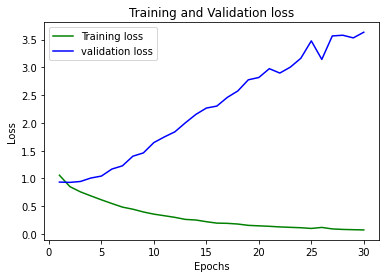

In [154]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,31)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


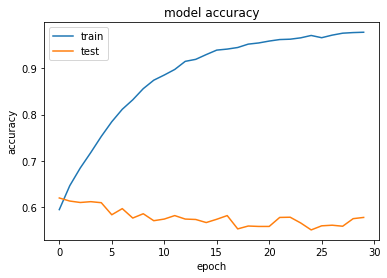

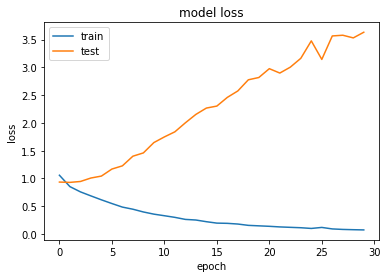

In [155]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [156]:
test = pd.read_csv('validation_clean_removed_emoticons.csv')
test_text = test["Review Text"].values
test_text = [str(x).lower() for x in test_text]

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen=max_length)

y_test = test["Rating"].values


In [157]:
p = model.predict(data)
y_pred = []
for prediction in p:
    y_pred.append(np.argmax(prediction, axis=0))

In [158]:
print(confusion_matrix(y_test, y_pred))

[[   0    0    0    0   82]
 [   0    0    0    0  157]
 [   0    0    0    0  282]
 [   0    0    0    0  495]
 [   0    0    0    0 1246]]


In [159]:
print(f1_score(y_test, y_pred, average="micro"))

0.5508399646330681


In [160]:
# model.save("rnn_model_0.55")